In [23]:
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pylab as plt
import math

### Data overview

In [6]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O shakespear.txt

--2023-03-03 09:52:37--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespear.txt’

shakespear.txt      100%[===================>]   1.06M  --.-KB/s    in 0.006s  

2023-03-03 09:52:37 (182 MB/s) - ‘shakespear.txt’ saved [1115394/1115394]



In [2]:
with open('shakespear.txt', 'r', encoding='utf-8') as fr:
    text = fr.read()

In [3]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocab size: {vocab_size}")
print("".join(chars))

Vocab size: 65

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [5]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos  = {i:ch for i,ch in enumerate(chars)}

encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: "".join([itos[i] for i in l])

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [7]:
n = int(0.9*len(data))
train_data, valid_data = data[:n], data[n:]
print(train_data.shape, valid_data.shape)

torch.Size([1003854]) torch.Size([111540])


In [8]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [9]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(context, target)
    

tensor([18]) tensor(47)
tensor([18, 47]) tensor(56)
tensor([18, 47, 56]) tensor(57)
tensor([18, 47, 56, 57]) tensor(58)
tensor([18, 47, 56, 57, 58]) tensor(1)
tensor([18, 47, 56, 57, 58,  1]) tensor(15)
tensor([18, 47, 56, 57, 58,  1, 15]) tensor(47)
tensor([18, 47, 56, 57, 58,  1, 15, 47]) tensor(58)


In [10]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split):
    data = train_data if split == 'train' else valid_data
    ix = torch.randint(0, len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [19]:
xb, yb = get_batch('train')
xb, yb

(tensor([[24, 43, 58,  5, 57,  1, 46, 43],
         [44, 53, 56,  1, 58, 46, 39, 58],
         [52, 58,  1, 58, 46, 39, 58,  1],
         [25, 17, 27, 10,  0, 21,  1, 54]]),
 tensor([[43, 58,  5, 57,  1, 46, 43, 39],
         [53, 56,  1, 58, 46, 39, 58,  1],
         [58,  1, 58, 46, 39, 58,  1, 46],
         [17, 27, 10,  0, 21,  1, 54, 39]]))

In [20]:
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(context, target)

tensor([24]) tensor(43)
tensor([24, 43]) tensor(58)
tensor([24, 43, 58]) tensor(5)
tensor([24, 43, 58,  5]) tensor(57)
tensor([24, 43, 58,  5, 57]) tensor(1)
tensor([24, 43, 58,  5, 57,  1]) tensor(46)
tensor([24, 43, 58,  5, 57,  1, 46]) tensor(43)
tensor([24, 43, 58,  5, 57,  1, 46, 43]) tensor(39)
tensor([44]) tensor(53)
tensor([44, 53]) tensor(56)
tensor([44, 53, 56]) tensor(1)
tensor([44, 53, 56,  1]) tensor(58)
tensor([44, 53, 56,  1, 58]) tensor(46)
tensor([44, 53, 56,  1, 58, 46]) tensor(39)
tensor([44, 53, 56,  1, 58, 46, 39]) tensor(58)
tensor([44, 53, 56,  1, 58, 46, 39, 58]) tensor(1)
tensor([52]) tensor(58)
tensor([52, 58]) tensor(1)
tensor([52, 58,  1]) tensor(58)
tensor([52, 58,  1, 58]) tensor(46)
tensor([52, 58,  1, 58, 46]) tensor(39)
tensor([52, 58,  1, 58, 46, 39]) tensor(58)
tensor([52, 58,  1, 58, 46, 39, 58]) tensor(1)
tensor([52, 58,  1, 58, 46, 39, 58,  1]) tensor(46)
tensor([25]) tensor(17)
tensor([25, 17]) tensor(27)
tensor([25, 17, 27]) tensor(10)
tensor([25

### Attention

#### v1

In [21]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.randn((B, T, C))
xbow = torch.randn((B, T, C))

for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1]
        # takes just context from curent and previous positions and average
        xbow[b,t] = torch.mean(xprev, axis=0)

In [22]:
x[0][:3], xbow[0][:3]

(tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199]]))

#### v2

In [24]:
wei = torch.tril(torch.ones((T,T)))
wei

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [25]:
wei  = wei / wei.sum(dim=1, keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [28]:
xbow2 = wei @ x
torch.allclose(xbow2, xbow)

True

#### v3

In [29]:
tril = torch.tril(torch.ones((T, T)))
# this should be trainable in the future vertsion
wei  = torch.zeros((T, T))
wei = F.softmax(wei.masked_fill(tril == 0, -float('inf')), dim=1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [30]:
torch.allclose(wei @ x, xbow)

True

### Self attention module

#### Core

In [31]:
# self attention
torch.manual_seed(1337)
B, T, C = 4, 8, 32
head_size = 16
x = torch.randn((B, T, C))

# in case of cross attention key & value come from encoder part
key = nn.Linear(C, head_size, bias=False) 
value = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)

k = key(x) # B T head_size
q = query(x) # B T head_size
v = value(x) # B T head_size

wei = q @ k.transpose(-2, -1) # B T head_size @ B head_size T -> B T T
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf')) # difference between autoencoder and generator
wei = F.softmax(wei, dim=-1)

out = wei @ v
out.shape

torch.Size([4, 8, 16])

In [32]:
wei.shape, v.shape

(torch.Size([4, 8, 8]), torch.Size([4, 8, 16]))

In [40]:
torch.round(wei[0], decimals=1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7000, 0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7000, 0.2000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.8000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.8000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.2000, 0.1000, 0.2000, 0.0000, 0.2000, 0.0000],
        [0.0000, 0.2000, 0.1000, 0.2000, 0.2000, 0.0000, 0.1000, 0.1000]],
       grad_fn=<RoundBackward1>)

In [17]:
out.shape

torch.Size([4, 8, 16])

#### Variance scaling

In [41]:
# Note on variance
q = torch.randn(B, T, head_size)
k = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1)
print(q.var(), k.var(), wei.var(), head_size)

q = torch.randn(B, T, head_size)
k = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5
print(q.var(), k.var(), wei.var(), head_size, head_size**-0.5)

tensor(1.0449) tensor(1.0700) tensor(17.4690) 16
tensor(0.9006) tensor(1.0037) tensor(0.9957) 16 0.25


In [46]:
# In case distribution is sharp, softmax is peaky and takes extremes
torch.round(F.softmax(torch.tensor([[-2,2,5]], dtype=torch.float)), decimals=3), torch.round(F.softmax(torch.tensor([[-2,2,5]], dtype=torch.float) * 5), decimals=5)

/tmp/ipykernel_77349/3604809417.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.round(F.softmax(torch.tensor([[-2,2,5]], dtype=torch.float)), decimals=3), torch.round(F.softmax(torch.tensor([[-2,2,5]], dtype=torch.float) * 5), decimals=5)


(tensor([[0.0010, 0.0470, 0.9520]]), tensor([[0., 0., 1.]]))

#### Use one matrix for multihead

In [96]:
# self attention
torch.manual_seed(1337)
B, T, C = 4, 8, 32
heads = 1
n_embed = 16
n_hembed = int(n_embed / heads)
x = torch.randn((B, T, C))

# in case of cross attention key & value come from encoder part
key = nn.Linear(C, n_hembed, bias=False) 
value = nn.Linear(C, n_hembed, bias=False)
query = nn.Linear(C, n_hembed, bias=False)

k = key(x) # B T head_size
q = query(x) # B T head_size
v = value(x) # B T head_size

wei = q @ k.transpose(-2, -1) # B T head_size @ B head_size T -> B T T
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf')) # difference between autoencoder and generator
wei = F.softmax(wei, dim=-1)

out = wei @ v
out.shape

torch.Size([4, 8, 16])

In [97]:
key

Linear(in_features=32, out_features=16, bias=False)

In [98]:
key.weight.shape

torch.Size([16, 32])

In [99]:
torch.cat([out, out], dim=-1).shape

torch.Size([4, 8, 32])

In [134]:
w = torch.cat([query.weight for _ in range(heads)] + [key.weight for _ in range(heads)] + [value.weight for _ in range(heads)], dim=0)
c_attn = nn.Linear(w.shape[1], w.shape[0], bias=False)
with torch.no_grad():
    c_attn.weight = nn.Parameter(w) 

In [135]:
c_attn

Linear(in_features=32, out_features=48, bias=False)

In [138]:
torch.allclose(c_attn.weight[:n_hembed], query.weight)

True

In [136]:
qq, kk, vv = c_attn(x).split(n_embed, dim=2)

In [137]:
qq.view(B, T, heads, n_hembed).transpose(1, 2)[0][0]

tensor([[-0.1571,  0.8801,  0.1615, -0.7824, -0.1429,  0.7468,  0.1007, -0.5239,
         -0.8873,  0.1907,  0.1762, -0.5943, -0.4812, -0.4860,  0.2862,  0.5710],
        [ 0.8321, -0.8144, -0.3242,  0.5191, -0.1252, -0.4898, -0.5287, -0.0314,
          0.1072,  0.8269,  0.8132, -0.0271,  0.4775,  0.4980, -0.1377,  1.4025],
        [ 0.6035, -0.2500, -0.6159,  0.4068,  0.3328, -0.3910,  0.1312,  0.2172,
         -0.1299, -0.8828,  0.1724,  0.4652, -0.4271, -0.0768, -0.2852,  1.3875],
        [ 0.6657, -0.7096, -0.6099,  0.4348,  0.8975, -0.9298,  0.0683,  0.1863,
          0.5400,  0.2427, -0.6923,  0.4977,  0.4850,  0.6608,  0.8767,  0.0746],
        [ 0.1536,  1.0439,  0.8457,  0.2388,  0.3005,  1.0516,  0.7637,  0.4517,
         -0.7426, -1.4395, -0.4941, -0.3709, -1.1819,  0.1000, -0.1806,  0.5129],
        [-0.8920,  0.0578, -0.3350,  0.8477,  0.3876,  0.1664, -0.4587, -0.5974,
          0.4961,  0.6548,  0.0548,  0.9468,  0.4511,  0.1200,  1.0573, -0.2257],
        [-0.4849,  0.1

In [141]:
torch.allclose(q[0], qq.view(B, T, heads, n_hembed).transpose(1, 2)[0][0])

True

In [133]:
k=0
c_attn(x)[0][0][k*n_embed:(k+1)*n_embed], q[0][0]

(tensor([-0.1571,  0.8801,  0.1615, -0.7824, -0.1429,  0.7468,  0.1007, -0.5239,
         -0.8873,  0.1907,  0.1762, -0.5943, -0.4812, -0.4860,  0.2862,  0.5710],
        grad_fn=<SliceBackward0>),
 tensor([-0.1571,  0.8801,  0.1615, -0.7824, -0.1429,  0.7468,  0.1007, -0.5239,
         -0.8873,  0.1907,  0.1762, -0.5943, -0.4812, -0.4860,  0.2862,  0.5710],
        grad_fn=<SelectBackward0>))

### Batch nomr 1d

In [12]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
    def __call__(self, x):
        xmean = x.mean(dim=1, keepdim=True)
        xvar = x.var(dim=1, keepdim=True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        return self.gamma * xhat + self.beta
    
    def parameters(self):
        return [self.gamam, self.beta]

In [16]:
torch.manual_seed(1337)
bn = BatchNorm1d(100)

x = torch.randn(32, 100)
x = bn(x)

In [18]:
x[0, :].mean(), x[0, :].std(), ((x[1, :] - x[1, :].mean())/x[1, :].std()).mean(),  ((x[1, :] - x[1, :].mean())/x[1, :].std()).std()

(tensor(-9.5367e-09), tensor(1.0000), tensor(9.5367e-09), tensor(1.))

### GELU

In [24]:
def new_gelu(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

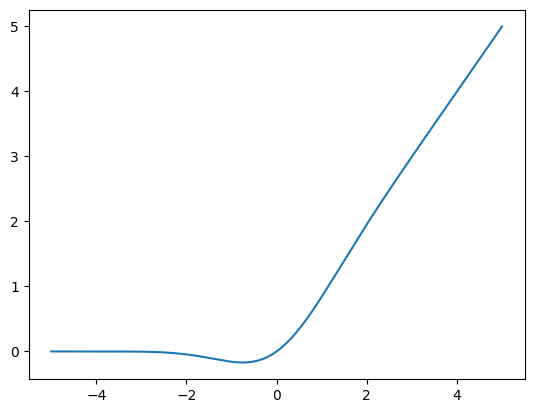

In [27]:
plt.plot(np.linspace(-5,5, 200), list(map(lambda x: new_gelu(torch.tensor(x)), np.linspace(-5,5,200))))

### Optimmizer setup

In [148]:
from decoder import DecoderModel
from config import decoder_config as config
config.vocab_size = 100

In [149]:
model = DecoderModel(config)

In [151]:
model

DecoderModel(
  (token_embedding_table): Embedding(100, 384)
  (position_embedding_table): Embedding(64, 384)
  (blocks): Sequential(
    (0): Block(
      (sa_head): MultiHeadAttentionV2(
        (c_attn): Linear(in_features=384, out_features=1152, bias=False)
        (c_proj): Linear(in_features=384, out_features=384, bias=False)
        (attn_dropout): Dropout(p=0.2, inplace=False)
        (resid_dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (c_fc): Linear(in_features=384, out_features=1536, bias=False)
        (c_proj): Linear(in_features=1536, out_features=384, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
      (sa_head): MultiHeadAttentionV2(
        (c_attn): Linear(in_features=384, out_features=1152, bias=False)
        (c_proj): Linear(in_features=384, out_feature

In [157]:
# separate out all parameters to those that will and won't experience regularizing weight decay
decay = set()
no_decay = set()
whitelist_weight_modules = (torch.nn.Linear, )
blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
for mn, m in model.named_modules():
    for pn, p in m.named_parameters():
        fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
        # random note: because named_modules and named_parameters are recursive
        # we will see the same tensors p many many times. but doing it this way
        # allows us to know which parent module any tensor p belongs to...
        if pn.endswith('bias'):
            # all biases will not be decayed
            no_decay.add(fpn)
        elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
            # weights of whitelist modules will be weight decayed
            decay.add(fpn)
        elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
            # weights of blacklist modules will NOT be weight decayed
            no_decay.add(fpn)

In [158]:
# l2 regularized
decay

{'blocks.0.ffwd.c_fc.weight',
 'blocks.0.ffwd.c_proj.weight',
 'blocks.0.sa_head.c_attn.weight',
 'blocks.0.sa_head.c_proj.weight',
 'blocks.1.ffwd.c_fc.weight',
 'blocks.1.ffwd.c_proj.weight',
 'blocks.1.sa_head.c_attn.weight',
 'blocks.1.sa_head.c_proj.weight',
 'blocks.2.ffwd.c_fc.weight',
 'blocks.2.ffwd.c_proj.weight',
 'blocks.2.sa_head.c_attn.weight',
 'blocks.2.sa_head.c_proj.weight',
 'lm_head.weight'}

In [159]:
no_decay

{'blocks.0.ln1.bias',
 'blocks.0.ln1.weight',
 'blocks.0.ln2.bias',
 'blocks.0.ln2.weight',
 'blocks.1.ln1.bias',
 'blocks.1.ln1.weight',
 'blocks.1.ln2.bias',
 'blocks.1.ln2.weight',
 'blocks.2.ln1.bias',
 'blocks.2.ln1.weight',
 'blocks.2.ln2.bias',
 'blocks.2.ln2.weight',
 'ln_f.bias',
 'ln_f.weight',
 'position_embedding_table.weight',
 'token_embedding_table.weight'}

### Next